## Accessing gNATSGO data with the Planetary Computer STAC API

The gridded National Soil Survey Geographic Database (gNATSGO) is a USDA-NRCS Soil & Plant Science Division (SPSD) composite database that provides complete coverage of the best available soils information for all areas of the United States and Island Territories.

gNATSGO data in the Planetary Computer is provided in two complimentary collections: one containing raster data, and one containing the associated tabular data. 

The raster catalog a number of layers are pre-summarized to the map unit level using best-practice generalization methods intended to meet the needs of most users, as well as a layer which provides the map-unit key (`mukey`) which allows users to join tables from the tables collection for more advanced soil mapping.

In this example, we will explore the pre-summarized raster assets, and perform a simple join to the tabular data.

### Setup environment

In [1]:
import planetary_computer
import numpy as np
import pandas as pd
import rioxarray
import xarray
from pystac_client import Client

### Rasters 

Let's start by finding the tile which contains Marshall County, IA and inspecting the stac item for which assets are available.

In [2]:
client = Client.open("https://pct-apis-staging.westeurope.cloudapp.azure.com/stac")

marshall_county = [-92.99900, 42.03580]
search = client.search(
    collections=["gnatsgo-rasters"],
    intersects={"type": "Point", "coordinates": marshall_county},
)
items = list(search.get_items())
print(f"Returned {len(items)} items")
raster_item = items[0]
print(raster_item.assets.keys())

Returned 1 items
dict_keys(['mukey', 'aws0_5', 'soc0_5', 'tk0_5a', 'tk0_5s', 'aws0_20', 'aws0_30', 'aws5_20', 'soc0_20', 'soc0_30', 'soc5_20', 'tk0_20a', 'tk0_20s', 'tk0_30a', 'tk0_30s', 'tk5_20a', 'tk5_20s', 'aws0_100', 'aws0_150', 'aws0_999', 'aws20_50', 'droughty', 'nccpi3sg', 'soc0_100', 'soc0_150', 'soc0_999', 'soc20_50', 'tk0_100a', 'tk0_100s', 'tk0_150a', 'tk0_150s', 'tk0_999a', 'tk0_999s', 'tk20_50a', 'tk20_50s', 'aws50_100', 'musumcpct', 'nccpi3all', 'nccpi3cot', 'nccpi3soy', 'pwsl1pomu', 'rootznaws', 'rootznemc', 'soc50_100', 'tk50_100a', 'tk50_100s', 'aws100_150', 'aws150_999', 'musumcpcta', 'musumcpcts', 'nccpi3corn', 'pctearthmc', 'soc100_150', 'soc150_999', 'tk100_150a', 'tk100_150s', 'tk150_999a', 'tk150_999s'])


We can open the asset for Soil Organic Carbon in the top 20cm using `rioxarray` and display the map.

Soil organic carbon stock estimate (SOC) in standard zone 2 (0-20 cm depth). The concentration of organic carbon present in the soil expressed in grams C per square meter to a depth of 20 cm. NULL values are presented where data are incomplete or not available.


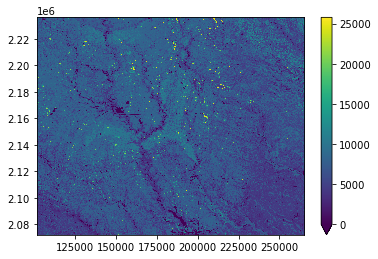

In [3]:
signed_asset = planetary_computer.sign(raster_item.assets["soc0_20"])
data = (
    rioxarray.open_rasterio(signed_asset.href)
    .squeeze()
    .drop("band")
    .coarsen({"y": 8, "x": 8})
    .mean()
)

print(raster_item.assets["soc0_20"].description)
data.plot.imshow(vmin=0, add_labels=False)

### Tabular data

Beyond the pre-summarized rasters provided, gNATSGO includes around 70 tables containing a wide variety of data on the soil, crops, and more. These tables can be joined to the `mukey` raster asset to map additional quantities. 

As a simple example, we will load the `muaggatt` table which provides some additional quantities that have already been aggregated to the map-unit scale. First, find the item and use `planetary_computer` to `sign` it.

In [4]:
gnatsgo_tables = client.get_collection("gnatsgo-tables")
muaggatt_item = gnatsgo_tables.get_item("muaggatt")
muaggatt_item = planetary_computer.sign(muaggatt_item)

The tables are stored in parquet format, which allows us to efficiently load only the columns we are interested in. Let's load some data on slope (`slopegraddcp`) into a pandas dataframe.

In [5]:
muaggatt_table = pd.read_parquet(
    muaggatt_item.assets["data"].href,
    columns=["mukey", "slopegraddcp"],
    storage_options=muaggatt_item.assets["data"].extra_fields["table:storage_options"],
    engine="pyarrow",
)
muaggatt_table = muaggatt_table.set_index("mukey")
muaggatt_table["slopegraddcp"] = muaggatt_table["slopegraddcp"].fillna(0)

Now we can read the `mukey` raster for our Marshall County tile and create a derived raster by joining to the slope column.

In [ ]:
signed_asset = planetary_computer.sign(raster_item.assets["mukey"])
mukey = rioxarray.open_rasterio(signed_asset.href).squeeze().drop("band")

unique_mukeys, inverse = np.unique(mukey, return_inverse=True)
slope_raster = (
    muaggatt_table["slopegraddcp"]
    .groupby(level=0)
    .first()
    .reindex(unique_mukeys, fill_value=0)
    .to_numpy()[inverse]
    .reshape(mukey.shape)
)

# slope_raster = np.array(
#    [muaggatt_table["slopegraddcp"].get(mk, 0) for mk in unique_mukeys]
# )[inverse].reshape(mukey.shape)

col = next(
    col
    for col in muaggatt_item.properties["table:columns"]
    if col["name"] == "slopegraddcp"
)
print(col["description"])
xarray.DataArray(slope_raster).plot.imshow()

The difference is elevation between two points, expressed as a percentage of the distance between those points.  This column displays the slope gradient of the dominant component of the map unit based on composition percentage.
